In [1]:

# import basic modules
import sys
import os
import time
import numpy as np
from tqdm import tqdm
import gc
import torch
import argparse
import skimage.transform

# import custom modules
code_dir = '/user_data/mmhender/imStat/code/'
sys.path.append(code_dir)

from utils import nsd_utils, roi_utils, default_paths, prf_utils
from model_fitting import initialize_fitting as initialize_fitting

fpX = np.float32
device = initialize_fitting.init_cuda()

#device: 1
device#: 0
device name: GeForce GTX TITAN X

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [52]:
which_grid = 3

aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=1.1, which_grid=which_grid)

number of pRFs: 1114
most extreme RF positions:
[-0.55 -0.55  0.04]
[ 0.  0. 10.]


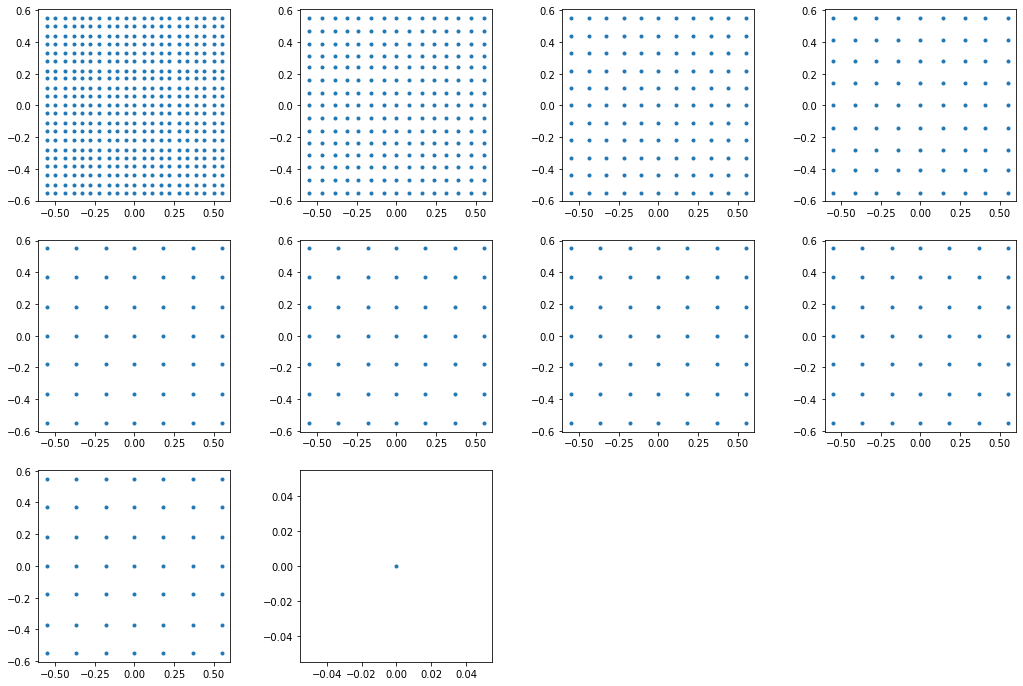

In [53]:
import matplotlib.pyplot as plt

models = np.round(models, 2)
unique_sizes = np.unique(models[:,2])
plt.figure(figsize=(18,12));

for si, size in enumerate(unique_sizes):
    
    inds = np.where(models[:,2]==size)[0]
    plt.subplot(3,4,si+1)
    plt.plot(models[inds,0], models[inds,1], '.')
    
    plt.axis('square')

[0.0, 0.0, 0.04]


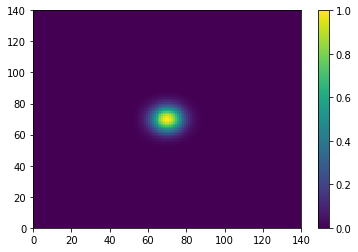

In [27]:
x,y,sigma = models[220,:]
print([x,y,sigma])
n_pix = 140
aperture = 1.0
prf = prf_utils.gauss_2d(center=[x,y], sd=sigma, patch_size=n_pix, aperture=1.0)

minval = np.min(prf)
maxval = np.max(prf-minval)
prf_scaled = (prf - minval)/maxval

prf1 = prf_scaled

plt.figure();
plt.pcolormesh(prf_scaled)
plt.colorbar()

In [22]:
np.where((models[:,0]==0)&(models[:,1]==0.0))

(array([ 220,  553,  726,  827,  892,  941,  990, 1039, 1088, 1113]),)

[0.0, 0.0, 0.04]


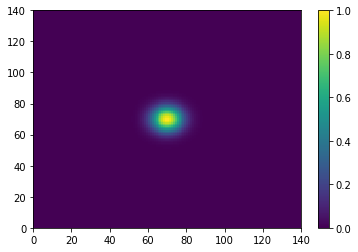

In [26]:
x,y,sigma = models[220,:]
print([x,y,sigma])
n_pix = 140
aperture = 1.0
prf = prf_utils.make_gaussian_mass(x, y, sigma, n_pix, size=aperture, \
                          dtype=np.float32)[2]
minval = np.min(prf)
maxval = np.max(prf-minval)
prf_scaled = (prf - minval)/maxval

prf2 = prf_scaled

plt.figure();
plt.pcolormesh(prf_scaled)
plt.colorbar()

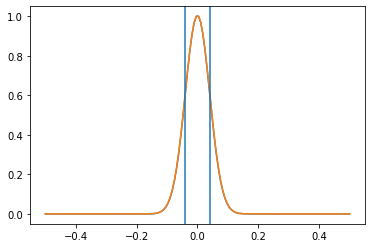

In [28]:
plt.figure();
plt.plot(np.linspace(-0.5, 0.5, n_pix), prf1[int(np.ceil(n_pix/2)),:])
plt.plot(np.linspace(-0.5, 0.5, n_pix), prf2[int(np.ceil(n_pix/2)),:])
plt.axvline(-sigma)
plt.axvline(sigma)

In [60]:
from utils import torch_utils
which_grid = 2
mm = 110
prf_models = models

prf_params = prf_models[mm,:]
x,y,sigma = prf_params
print('Getting features for pRF [x,y,sigma]:')
print([x,y,sigma])
# n_pix = maps_full_field.shape[1]
n_pix = 14
# Define the RF for this "model" version
if which_grid==3:
    prf = torch_utils._to_torch(prf_utils.gauss_2d(center=[x,y], sd=sigma, \
                                       patch_size=n_pix, aperture=aperture), device=device)
else:
    prf = torch_utils._to_torch(prf_utils.make_gaussian_mass(x, y, sigma, n_pix, size=aperture, \
                              dtype=np.float32)[2], device=device)
minval = torch.min(prf)
maxval = torch.max(prf-minval)
prf_scaled = (prf - minval)/maxval

if sigma==10:
    # creating a "flat" pRF here which will average across entire feature map.
    prf_scaled = torch.ones(prf_scaled.shape)
    prf_scaled = prf_scaled/torch.sum(prf_scaled)


Getting features for pRF [x,y,sigma]:
[-0.28, -0.28, 0.04]


In [62]:
from utils import texture_utils
n_prf_sd_out=2
bbox = texture_utils.get_bbox_from_prf(prf_params, prf.shape, n_prf_sd_out, \
                                                       min_pix=None, verbose=False, force_square=False)
print('bbox to crop is:')
bbox


bbox to crop is:


[8, 13, 1, 6]

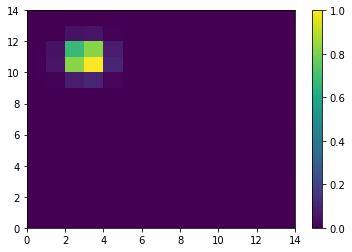

In [61]:
plt.figure();
plt.pcolormesh(prf_scaled.detach().cpu().numpy())
plt.colorbar()

In [42]:
torch.sum(prf_scaled)

tensor(1.)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


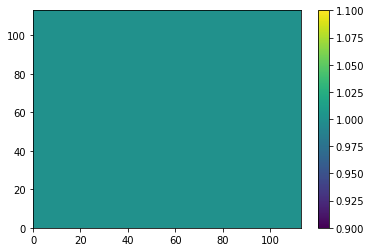

In [80]:
# x,y,sigma = models[1112,:]
x,y,sigma = 0,0,2
n_pix = 113
aperture = 1.0
prf2 = make_gaussian_mass(x, y, sigma, n_pix, size=aperture, \
                          dtype=np.float32)[2]
minval = np.min(prf2)
maxval = np.max(prf2-minval)
prf2_scaled = (prf2 - minval)/maxval

plt.figure();
plt.pcolormesh(prf2)
plt.colorbar()

In [83]:
prf2_scaled

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [78]:
def gaussian_mass(xi, yi, dx, dy, x, y, sigma):
    return 0.25*(erf((xi-x+dx/2)/(np.sqrt(2)*sigma)) - erf((xi-x-dx/2)/(np.sqrt(2)*sigma)))*(erf((yi-y+dy/2)/(np.sqrt(2)*sigma)) - erf((yi-y-dy/2)/(np.sqrt(2)*sigma)))
    
def make_gaussian_mass(x, y, sigma, n_pix, size=None, dtype=np.float32):
    deg = dtype(n_pix) if size==None else size
    dpix = dtype(deg) / n_pix
    pix_min = -deg/2. + 0.5 * dpix
    pix_max = deg/2.
    [Xm, Ym] = np.meshgrid(np.arange(pix_min,pix_max,dpix), np.arange(pix_min,pix_max,dpix));
    if sigma<=0:
        Zm = np.zeros_like(Xm)
    elif sigma<dpix:
        g_mass = np.vectorize(lambda a, b: gaussian_mass(a, b, dpix, dpix, x, y, sigma)) 
        Zm = g_mass(Xm, -Ym)        
    else:
        d = (2*dtype(sigma)**2)
        A = dtype(1. / (d*np.pi))
        Zm = dpix**2 * A * np.exp(-((Xm-x)**2 + (-Ym-y)**2) / d)
    if sigma>1:
        Zm = np.ones(np.shape(Zm))
        
    return Xm, -Ym, Zm.astype(dtype)

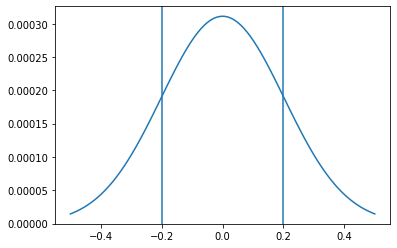

In [61]:
plt.figure();
plt.plot(np.linspace(-0.5, 0.5, n_pix), prf[int(np.ceil(n_pix/2)),:])
plt.axvline(-sigma)
plt.axvline(sigma)